# HW4: Structure-from-motion

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import hw3

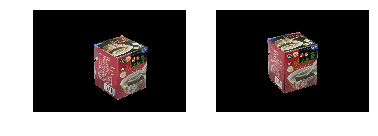

In [18]:
image1 = cv2.imread('./data/Mesona1.JPG')
image2 = cv2.imread('./data/Mesona2.JPG')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image1), plt.axis('off')
plt.subplot(122), plt.imshow(image2), plt.axis('off')
plt.show()

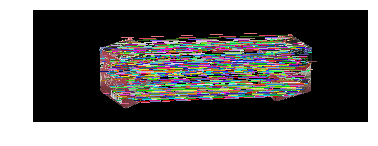

(<matplotlib.image.AxesImage at 0x26b02251ef0>,
 (-0.5, 2399.5, 799.5, -0.5),
 None)

In [19]:
sift = cv2.xfeatures2d.SIFT_create()

(keypt1, desc1) = sift.detectAndCompute(image1, None)
(keypt2, desc2) = sift.detectAndCompute(image2, None)

BF_MACTHEr_DISTANCE = 0.65
matches = hw3.brute_force_matcher(desc1, desc2, BF_MACTHEr_DISTANCE)
matched_pt_order = hw3.sort_matched_points(matches)

matched_feature_image = hw3.show_matched_image(image1, image2, keypt1, keypt2, matched_pt_order)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()